<a href="https://colab.research.google.com/github/konucha/SentimentAnalisis/blob/main/preprocess_data_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from numpy import random
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/Shareddrives/capstone-project-c22-ps085/ML/dataset/trashnet_data"
os.listdir(base_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['constants.py',
 'dataset-original.zip',
 'dataset-resized.zip',
 'README.txt',
 'resize.py',
 'data',
 'Copy of preprocess_data (1).ipynb',
 'Copy of preprocess_data.ipynb',
 'preprocess_data.ipynb',
 'preprocess_data_kncx.ipynb',
 'saved_model',
 'preprocess_data_fix.ipynb',
 'mymodel.h5']

## unzipping data set

In [ ]:
# try:
#   dir = 'data'
#   path = os.path.join(base_path, dir)
#   os.mkdir(path)
#   print("Directory created")
# except FileExistsError:
#   print("Directory existed")

# data_zip = 'dataset-resized.zip'
# dir = os.path.join(base_path, 'data')
# with zipfile.ZipFile(os.path.join(base_path, data_zip), 'r') as zip_ref:
#     zip_ref.extractall(dir)

In [ ]:
dataset_path = os.path.join(base_path, 'data', 'dataset-resized')
print(os.listdir(dataset_path))

# remove .hidden 
try:
  os.remove(os.path.join(dataset_path, '.DS_Store'))
  print('File .DS_Store deleted')
except FileNotFoundError:
  pass

['trash', 'cardboard', 'glass', 'metal', 'paper', 'plastic']


## Check image detail

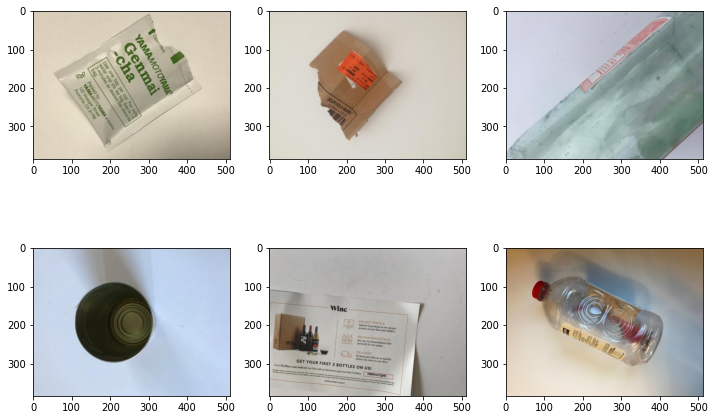

In [ ]:
def get_random_data_perclass():
  random_data_perclass = []

  for root, _, files in os.walk(dataset_path):
    # skip check folder in data_resized
    if len(files) == 0: continue
    random_index = random.randint(0, len(files) - 1)
    rand_data_path = os.path.join(root,  files[random_index])
    random_data_perclass.append(rand_data_path)
  return random_data_perclass

# subplot dimension
nrows = 2
ncols = 3

# Index for iterating over images
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i, img_path in enumerate(get_random_data_perclass()):
# Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('On')
  img = mpimg.imread(img_path)
  plt.imshow(img)
  # plt.title(class_image[i])


In [ ]:
# get all data path, per class

def get_all_image_path():
  data = []
  for root, dirs, files in os.walk(dataset_path):
    # skip check folder in data_resized
    if len(files) == 0: continue
    for file in files:
      img_path = os.path.join(root, file)
      data.append(img_path)
  
  return data
  
len(get_all_image_path())

2527

In [ ]:
# from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation

batch_size = 32
img_height = 384
img_width = 512

train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  shuffle=True,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


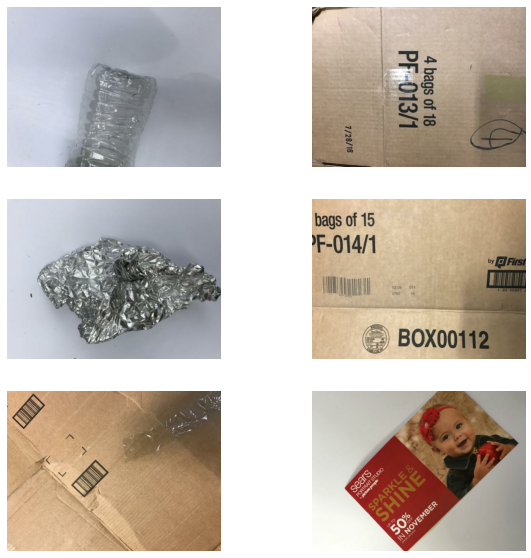

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(class_names[i])
    plt.axis("off")

## Image Augmentaion and Modeling

In [ ]:
# augmentastion
# IMG_HEIGHT = 192
# IMG_WIDTH = 256

IMG_HEIGHT = 384
IMG_WIDTH = 512
data_augmentation = tf.keras.Sequential([
  # tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH),                                        
  tf.keras.layers.Rescaling(1./255.),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation((-0.3,0.3)),
  tf.keras.layers.RandomZoom((-0.2,0.1)),
  tf.keras.layers.RandomTranslation(0.1,0.1)
])



In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(384, 512, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  data_augmentation,


  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # tf.keras.layers.Dropout(0.2),

  # tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  # tf.keras.layers.MaxPooling2D(2,2),
  # tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 382, 510, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 191, 255, 16)     0         
 g2D)                                                            
                                                                 
 sequential_12 (Sequential)  (None, 191, 255, 16)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 189, 253, 32)      4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 94, 126, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 92, 124, 64)     

In [ ]:
model.compile( #loss='categorical_crossentropy',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

## Training

In [ ]:
ACCURACY_THRESHOLD = 0.95
class myCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}): 
    if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
      print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
      self.model.stop_training = True

In [ ]:
callbacks = myCallback()
history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=200,
      callbacks=callbacks,
      verbose=1)

Epoch 1/200
64/64 [==============================] - 71s 741ms/step - loss: 3.7731 - accuracy: 0.2774 - val_loss: 1.4709 - val_accuracy: 0.3743
Epoch 2/200
64/64 [==============================] - 15s 230ms/step - loss: 1.4908 - accuracy: 0.3863 - val_loss: 1.4648 - val_accuracy: 0.3327
Epoch 3/200
64/64 [==============================] - 16s 243ms/step - loss: 1.3585 - accuracy: 0.4500 - val_loss: 1.4074 - val_accuracy: 0.4158
Epoch 4/200
64/64 [==============================] - 15s 229ms/step - loss: 1.3259 - accuracy: 0.4664 - val_loss: 1.2756 - val_accuracy: 0.5327
Epoch 5/200
64/64 [==============================] - 15s 231ms/step - loss: 1.2640 - accuracy: 0.5035 - val_loss: 1.3304 - val_accuracy: 0.5109
Epoch 6/200
64/64 [==============================] - 15s 232ms/step - loss: 1.2275 - accuracy: 0.5074 - val_loss: 1.1691 - val_accuracy: 0.5307
Epoch 7/200
64/64 [==============================] - 15s 230ms/step - loss: 1.2840 - accuracy: 0.5015 - val_loss: 1.3291 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


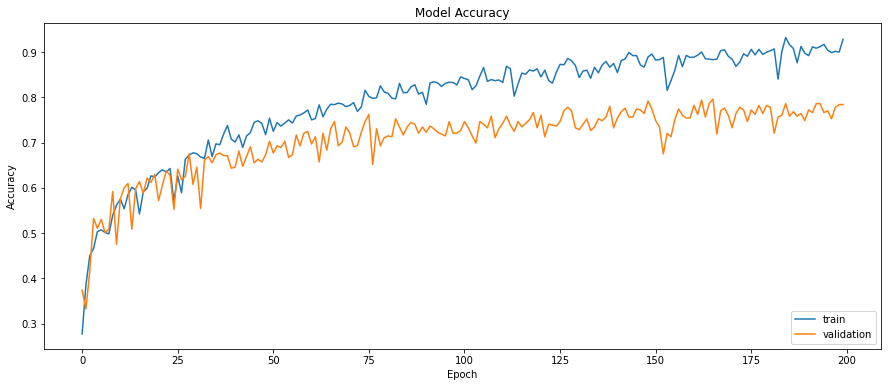

In [ ]:
print(history.history.keys())

# import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(15, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [ ]:
model.evaluate(train_ds)

64/64 [==============================] - 7s 97ms/step - loss: 0.1855 - accuracy: 0.9367


[0.18554408848285675, 0.9366963505744934]

In [ ]:
!mkdir -p $base_path/saved_model
model.save(f'{base_path}/saved_model/my_model')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/capstone-project-c22-ps085/ML/dataset/trashnet_data/saved_model/my_model/assets


In [ ]:
model.save( os.path.join(base_path, 'mymodel_200epoch.h5'))

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

# uploaded=files.upload()

# for fn in uploaded.keys():
 
# predicting images
path='/content/' + 'kertas.jpeg'
img=image.load_img(path, target_size=(384, 512))

x=image.img_to_array(img)
x /= 255.
x=np.expand_dims(x, axis=0)
images = np.vstack([x])

prediction = model.predict(images, batch_size=32)
print(prediction[0])
print(class_names)
# print(train_ds.indices)

[0. 0. 1. 0. 0. 0.]
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
